In [155]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split ,StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from spellchecker import SpellChecker
from nltk.stem.snowball import SnowballStemmer
import re
from tqdm import tqdm
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [16]:
data = pd.read_csv("spam.csv", encoding = "ISO-8859-1")

In [17]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [19]:
data = data[["v1","v2"]]

In [20]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [42]:
text = data["v2"]

In [74]:
labels = data["v1"]

In [60]:
sw = stopwords.words("english")
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [73]:
preprocessed_text = []
stemmer = SnowballStemmer('english')
checker = SpellChecker()

for sentence in tqdm(text):
    string = ""
    sentence = re.sub(r'[^A-Za-z ]', '',sentence)
    for word in word_tokenize(sentence):
        if word not in sw and len(word) > 1:
            pw = checker.correction(stemmer.stem(word))
            string += pw + " "
            
    preprocessed_text.append(string)
    

100%|██████████████████████████████████████████████████████████████████████████████| 5572/5572 [10:09<00:00,  9.14it/s]


In [70]:
preprocessed_text

['go jurons point crazy avail bug great world la buffet cine got amor wat ']

In [157]:
vectorizer = TfidfVectorizer(max_features = 1200)
data = vectorizer.fit_transform(preprocessed_text)
data = data.toarray()

In [158]:
data = pd.DataFrame(data)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
data["v1"] = labels

In [160]:
data["v1"].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [161]:
data["fold"] = -1

In [162]:
skf = StratifiedKFold(n_splits = 5)

for train_index , test_index in skf.split(data.drop(["v1"],axis = 1),data["v1"]):
    data.loc[test_index,"fold"] = 1
    break


In [163]:
Train = data[data["fold"] == -1]
Test = data[data["fold"] == 1]

In [164]:
Train["v1"].value_counts()

ham     3860
spam     597
Name: v1, dtype: int64

In [165]:
Xtrain = Train.drop(["fold","v1"],axis = 1)
Ytrain = Train["v1"]
Xtest = Test.drop(["fold","v1"],axis =1)
Ytest = Test["v1"]

In [166]:
model = RandomForestClassifier(n_jobs = -1)
model.fit(Xtrain,Ytrain)
pred = model.predict(Xtest)

Accuracy : 0.9811659192825112


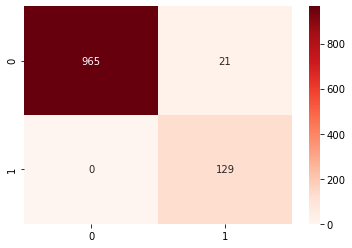

In [167]:
print("Accuracy :",accuracy_score(pred,Ytest))
sns.heatmap(confusion_matrix(pred , Ytest), annot=True, fmt='', cmap='Reds')
plt.show()

[16:26:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.9695067264573991


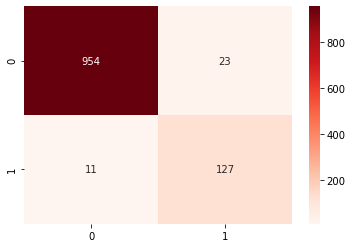

In [168]:
model2 = XGBClassifier(n_jobs = -1)
model2.fit(Xtrain,Ytrain)
pred2 = model2.predict(Xtest)

print("Accuracy :",accuracy_score(pred2,Ytest))
sns.heatmap(confusion_matrix(pred2 , Ytest), annot=True, fmt='', cmap='Reds')
plt.show()

Accuracy : 0.9704035874439462


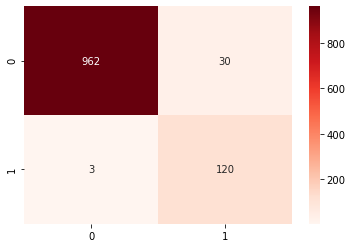

In [169]:
model3 = LogisticRegression(n_jobs = -1)
model3.fit(Xtrain,Ytrain)
pred3 = model3.predict(Xtest)

print("Accuracy :",accuracy_score(pred3,Ytest))
sns.heatmap(confusion_matrix(pred3, Ytest), annot=True, fmt='', cmap='Reds')
plt.show()

In [ ]:
model4 = SVC()
model4.fit(Xtrain,Ytrain)
pred4 = model4.predict(Xtest)

print("Accuracy :",accuracy_score(pred4,Ytest))
sns.heatmap(confusion_matrix(pred4, Ytest), annot=True, fmt='', cmap='Reds')
plt.show()

In [ ]:
model5 = GaussianNB()
model5.fit(Xtrain,Ytrain)
pred5 = model5.predict(Xtest)

print("Accuracy :",accuracy_score(pred5,Ytest))
sns.heatmap(confusion_matrix(pred5, Ytest), annot=True, fmt='', cmap='Reds')
plt.show()